In [1]:
import wandb
import pandas as pd

api = wandb.Api()

In [2]:
def reorder (pivoted_df):
    top_two_runs = ['Ensemble_all', 'LSTM_FFN']
    other_runs = [run for run in pivoted_df.index if run not in top_two_runs]
    new_order = top_two_runs + other_runs

    pivoted_df = pivoted_df.loc[new_order]

    return pivoted_df

def get_tables(run_ids):
    all_tables = []
    for run_name, run_id in run_ids.items():
        try:
            run = api.run(f"qianyue-university-of-stuttgart/teamlab_deepfake/runs/{run_id}")
            summary = run.summary._json_dict
            overall_eer = summary["eval_eer_overall"]
            eer_threshold = summary["eval_threshold_overall"]
        except wandb.errors.CommError as e:
            print(f"Could not find summary for run {run_name}: {e}")

        try:
            art = api.artifact(f"qianyue-university-of-stuttgart/teamlab_deepfake/run-{run_id}-per_attack_analysis_table:v0")
            table = art.get("per_attack_analysis_table")

            # Convert the wandb.Table to a pandas DataFrame
            # Following from the last code example:
            df = table.get_dataframe()

            #df = pd.DataFrame(table.data, columns=table.columns)
            df.loc[13] = ["ALL",overall_eer,eer_threshold,overall_eer,'nan']
            df['run_name'] = run_name
            all_tables.append(df)
        except wandb.errors.CommError as e:
            print(f"Could not find artifact for run {run_name}: {e}")

        combined_df = pd.concat(all_tables, ignore_index=True)

        df = combined_df.copy()
            
    df['EER'] = df['optimal_eer'].astype(float)
    df['FAR'] = df['far_at_global_threshold'].astype(float)

    # Select only the columns we need for the pivot
    df = df[['run_name', 'attack_type', 'EER', 'FAR']]


    pivoted_df = df.pivot_table(
        index='run_name',               # Each run gets its own row
        columns='attack_type',          # Each attack type becomes a column
        values=['EER', 'FAR']           # These are the values to fill the table
    )

    pivoted_df = reorder(pivoted_df)

    # swap the column levels to group by attack type
    pivoted_df.columns = pivoted_df.columns.swaplevel(0, 1)

    # Sort the columns to ensure a logical order
    pivoted_df = pivoted_df.sort_index(axis=1)

    # Format the final table for readability
    styled_df = pivoted_df.style.format("{:.2%}")

    print("--- Final Summary Table ---")
    display(styled_df)


    # PIVOT FOR EER 
    eer_df = df.pivot_table(
        index='run_name',
        columns='attack_type',
        values='EER'  # Request only the EER values
    )
    eer_df = reorder(eer_df)

    # PIVOT FOR FAR 
    far_df = df.pivot_table(
        index='run_name',
        columns='attack_type',
        values='FAR'  # Request only the FAR values
    )
    far_df = reorder(far_df)

    # Format and print both tables
    print("--- EER Summary Table ---")
    display(eer_df.style.format("{:.2%}"))

    print("\n--- FAR Summary Table ---")
    display(far_df.style.format("{:.2%}"))


In [3]:
# stable model - 11
run_ids_11 = {
    "Ensemble_all": "ey187sci",
    "CNN": "yt3etcul",
    "LSTM_FFN": "2rmr2frn",
    "Ensemble_A01": "ledjd762",
    "Ensemble_A02": "q0c4uoda",
    "Ensemble_A03": "rn0tcym5",
    "Ensemble_A04": "6v4weqjb",
    "Ensemble_A05": "066fevn9",
    "Ensemble_A06": "q8prlvxa"
}

# unstable model - 08
run_ids_08 = {
    "Ensemble_all": "5u8c67if",
    "CNN": "c391i1ub",
    "LSTM_FFN": "d61kmxsa",
    "Ensemble_A01": "xv2wv7j5",
    "Ensemble_A02": "kre4vj8n",
    "Ensemble_A03": "04pcde3v",
    "Ensemble_A04": "uaq2p1bm",
    "Ensemble_A05": "4epcsjyl",
    "Ensemble_A06": "q8wpakrk"
}

# good(maybe) model - 12
run_ids_12 = {
    "Ensemble_all": "iy7stjxs",
    "CNN": "pgpml4n7",
    "LSTM_FFN": "ylhwamom",
    "LSTM": "3vxp2dbg",
    "LSTM_pitch": "7guxcenz",
    "LSTM_hnr": "r5555u7z",
    "FFN": "lifu4lpv",
    "FFN_jitter": "4heuinbw",
    "FFN_shimmer": "52jyt8o0",
    "Ensemble_A01": "fmnwwxyu",
    "Ensemble_A02": "dsw1bo3l",
    "Ensemble_A03": "4x33z1n7",
    "Ensemble_A04": "3hz9ohht",
    "Ensemble_A05": "o8dynyxe",
    "Ensemble_A06": "b1u2uejo"
}

In [38]:
get_tables(run_ids_11)

KeyError: 'eval_eer_overall'

In [ ]:
get_tables(run_ids_08)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


--- Final Summary Table ---


--- EER Summary Table ---


attack_type,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19
run_name,,,,,,,,,,,,,
Ensemble_all,0.29%,8.44%,0.41%,0.41%,0.29%,2.20%,0.19%,0.26%,0.38%,1.28%,60.99%,79.36%,21.04%
LSTM_FFN,7.47%,11.56%,0.69%,4.23%,1.96%,1.55%,0.88%,0.86%,1.52%,2.40%,25.82%,54.84%,9.53%
CNN,7.67%,21.33%,5.09%,3.46%,3.82%,5.15%,1.97%,4.48%,4.34%,7.45%,45.68%,27.25%,29.10%
Ensemble_A01,0.29%,8.44%,0.41%,0.41%,0.29%,2.20%,0.19%,0.26%,0.38%,1.28%,60.99%,79.36%,21.04%
Ensemble_A02,39.70%,32.74%,8.59%,59.69%,27.19%,46.01%,40.83%,16.77%,30.67%,55.39%,54.93%,83.68%,30.71%
Ensemble_A03,61.54%,44.58%,24.77%,68.70%,53.75%,40.09%,80.28%,27.06%,34.59%,47.46%,78.12%,80.28%,84.43%
Ensemble_A04,84.47%,80.83%,30.28%,74.64%,66.18%,4.96%,82.92%,14.21%,7.15%,1.61%,34.03%,22.37%,45.03%
Ensemble_A05,35.35%,34.62%,15.87%,31.46%,19.70%,38.81%,9.03%,19.56%,30.13%,37.43%,25.87%,58.41%,18.98%
Ensemble_A06,69.03%,74.42%,17.69%,46.19%,32.15%,40.64%,14.83%,28.41%,36.28%,45.50%,18.94%,43.12%,5.45%



--- FAR Summary Table ---


attack_type,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19
run_name,,,,,,,,,,,,,
Ensemble_all,0.00%,8.32%,0.00%,0.00%,0.00%,0.22%,0.00%,0.00%,0.00%,0.06%,60.99%,79.37%,21.04%
LSTM_FFN,6.37%,11.36%,0.00%,0.75%,0.10%,0.00%,0.00%,0.02%,0.00%,0.39%,44.65%,87.08%,7.51%
CNN,3.58%,25.09%,1.71%,0.79%,0.90%,1.77%,0.06%,1.18%,1.14%,4.09%,78.80%,42.25%,47.80%
Ensemble_A01,0.00%,8.32%,0.00%,0.00%,0.00%,0.22%,0.00%,0.00%,0.00%,0.06%,60.99%,79.37%,21.04%
Ensemble_A02,39.23%,27.39%,0.85%,72.81%,17.62%,50.94%,41.09%,4.03%,20.82%,66.18%,66.18%,94.38%,25.15%
Ensemble_A03,63.59%,42.67%,8.10%,76.07%,52.97%,27.39%,92.12%,5.80%,19.37%,40.33%,94.36%,91.31%,97.68%
Ensemble_A04,95.48%,92.25%,23.83%,84.33%,74.09%,2.50%,95.81%,3.72%,0.69%,0.04%,29.65%,16.42%,46.87%
Ensemble_A05,43.20%,39.99%,3.60%,35.12%,10.26%,50.69%,0.51%,7.37%,31.32%,48.33%,21.49%,80.32%,8.79%
Ensemble_A06,92.10%,96.09%,3.85%,55.56%,27.05%,44.59%,2.26%,15.89%,35.00%,55.33%,6.04%,48.66%,0.20%


### Analysis

- `model_08` has a much less stable curve in development loss during training (with less regulation). Its overall on development set (0.43%) and testing set (12.31%) are lower than that of `model_11`, but the optimal EER/FAR for individual attacks on the later is less skewed over simpler tasks like TTS, which may indicate a worse generalizability if harder attacks are presented. 

- The attacks that degraded the performance of `model_08` are `A17`, `A18`, `A19`, which is aligned with the fact that these three models are more similar to bonafide speech and are generated based on real human voice. (`model_11` performs relatively poor on `A17` and `A18` too)

- Both `model_08` and `model_11` show an unusually high EER on `A08`, which is TTS attack and uses a similar method as `A01` (training set) and should be easy to detect. The baseline models provided by ASVSpoof19 performed well on `A08` though. The lower `A08` EER of the model trained on `A01` indicate that it does learn from the similarity (tho still higher than other TTS attacks), which the performance on `A08` is dragged behind by the influence of other attack types. $\to$ the model may captures the differnece between `A08` and other TTS-based attacks.

- The model trained on `A01` alone perform well on all attack types except for `A17`, `A18`, `A19`, which means it might (wait does `model_11` rely too much on `A01`?)

- `A13` is shown as a hard attack type to detect with both of ASVSpoof19 baseline models, but has a low EER rate in the current model, which can be resulted from good learning from `A01`, `A05`, and `A06`.

- TBA

- The high EER threshold in testing set indicates that there's high overlap between the scores in bonafide and spoof. Data augmentation may be needed to counter the imbalance and lack of variability in the testing/training set.

*TBD*
> continue with the third model which has better performance and a more normal threshold(training on individual attacks needed)

>something wrong with A01  

>maybe calculate mean and standard deviation on each testing attack type & similar attack types -> which one are maybe inherently easier to detect and which are harder? (also intra and inter group similarities & differences)

>maybe similarity between models trained on all features vs. single attack type -> which type does it learn more from?

>more investigation into each attack type

>calibration techniques (Z-norm, score shifting?)

In [4]:
get_tables(run_ids_12)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


--- Final Summary Table ---


--- EER Summary Table ---


attack_type,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,ALL
run_name,,,,,,,,,,,,,,
Ensemble_all,2.24%,5.56%,0.38%,0.94%,0.55%,0.79%,0.39%,0.42%,0.59%,0.94%,21.13%,47.26%,7.18%,10.17%
LSTM_FFN,2.93%,8.61%,0.38%,1.39%,0.65%,0.86%,0.53%,0.55%,0.90%,2.03%,23.60%,55.29%,8.77%,11.39%
CNN,13.00%,18.23%,4.21%,6.69%,6.21%,8.53%,6.17%,6.58%,5.39%,9.38%,41.06%,40.68%,31.89%,18.28%
Ensemble_A01,0.69%,2.57%,0.39%,0.75%,0.57%,5.19%,11.17%,0.35%,0.35%,4.01%,39.58%,61.19%,39.42%,17.55%
Ensemble_A02,83.07%,52.07%,44.35%,92.57%,75.58%,76.40%,97.92%,43.02%,57.49%,71.63%,53.54%,82.70%,32.17%,65.19%
Ensemble_A03,84.98%,55.25%,40.74%,90.15%,80.65%,68.74%,97.88%,43.71%,54.85%,65.04%,73.20%,77.39%,72.24%,68.43%
Ensemble_A04,33.01%,46.70%,2.62%,24.42%,18.62%,0.29%,19.09%,0.87%,0.45%,0.61%,32.74%,17.77%,45.73%,21.17%
Ensemble_A05,26.66%,26.66%,8.20%,22.37%,10.20%,44.14%,24.69%,9.46%,22.73%,43.69%,26.66%,76.15%,16.49%,26.66%
Ensemble_A06,81.42%,72.63%,34.31%,74.28%,57.36%,67.33%,90.72%,44.36%,53.87%,58.65%,19.11%,39.58%,4.52%,53.83%



--- FAR Summary Table ---


attack_type,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,ALL
run_name,,,,,,,,,,,,,,
Ensemble_all,0.20%,4.19%,0.00%,0.31%,0.02%,0.00%,0.00%,0.00%,0.00%,0.08%,39.70%,82.99%,4.64%,10.17%
LSTM_FFN,0.12%,7.47%,0.00%,0.45%,0.08%,0.02%,0.00%,0.00%,0.00%,0.33%,46.28%,87.51%,5.86%,11.39%
CNN,10.81%,18.21%,1.57%,3.40%,3.17%,5.23%,2.69%,3.36%,2.73%,6.37%,67.13%,64.77%,48.25%,18.28%
Ensemble_A01,0.08%,0.71%,0.00%,0.10%,0.02%,3.93%,8.79%,0.00%,0.00%,3.58%,75.50%,89.97%,56.84%,17.55%
Ensemble_A02,89.40%,47.19%,35.55%,98.51%,79.96%,82.42%,99.61%,32.66%,54.46%,76.43%,43.24%,90.44%,17.66%,65.19%
Ensemble_A03,88.60%,51.65%,26.52%,95.87%,85.37%,68.78%,99.86%,28.31%,45.83%,63.17%,77.86%,82.28%,75.50%,68.43%
Ensemble_A04,34.27%,51.59%,1.87%,25.05%,18.21%,0.00%,18.88%,0.06%,0.00%,0.02%,42.61%,15.89%,66.77%,21.17%
Ensemble_A05,32.72%,26.68%,0.85%,22.36%,2.75%,59.34%,24.68%,1.02%,22.73%,53.72%,34.55%,89.54%,10.24%,26.66%
Ensemble_A06,93.33%,87.28%,20.55%,84.98%,60.07%,74.50%,94.12%,37.83%,53.91%,62.15%,2.32%,28.67%,0.06%,53.83%


| Model | LR Scheduling | Regularization | Loss Curve  | Thresholds | EER Distribution   | Issue            |
| ----- | ------------- | -------------- | ----------- | ---------- | ------------------ | ------------------ |
| 1     | None        | Low           | Fluctuating | Abnormal   | Pooled: 12%; Skewed heavily     | Overfitting maybe|
| 2     | Yes & initial smaller         | High        | Smooth      | Abnormal   | Pooled: 23%; Balanced-ish       | Underfitting    |
| 3     | Yes         | Low         | Less Smooth      | Normal     | Pooled: 10%; Skewed reasonably | Good      |


### plots

wandb:   1 of 1 files downloaded.  


Sample DataFrame Head:
  attack_type  optimal_eer  optimal_threshold  far_at_global_threshold  \
0         A07     0.022409           0.330290                 0.002035   
1         A08     0.055582           0.812811                 0.041921   
2         A09     0.003837           0.000193                 0.000000   
3         A10     0.009371           0.032911                 0.003053   
4         A11     0.005466           0.003930                 0.000204   

   num_examples  
0          4914  
1          4914  
2          4914  
3          4914  
4          4914  

Sample DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   attack_type              13 non-null     object 
 1   optimal_eer              13 non-null     float64
 2   optimal_threshold        13 non-null     float64
 3   far_at_global_threshold

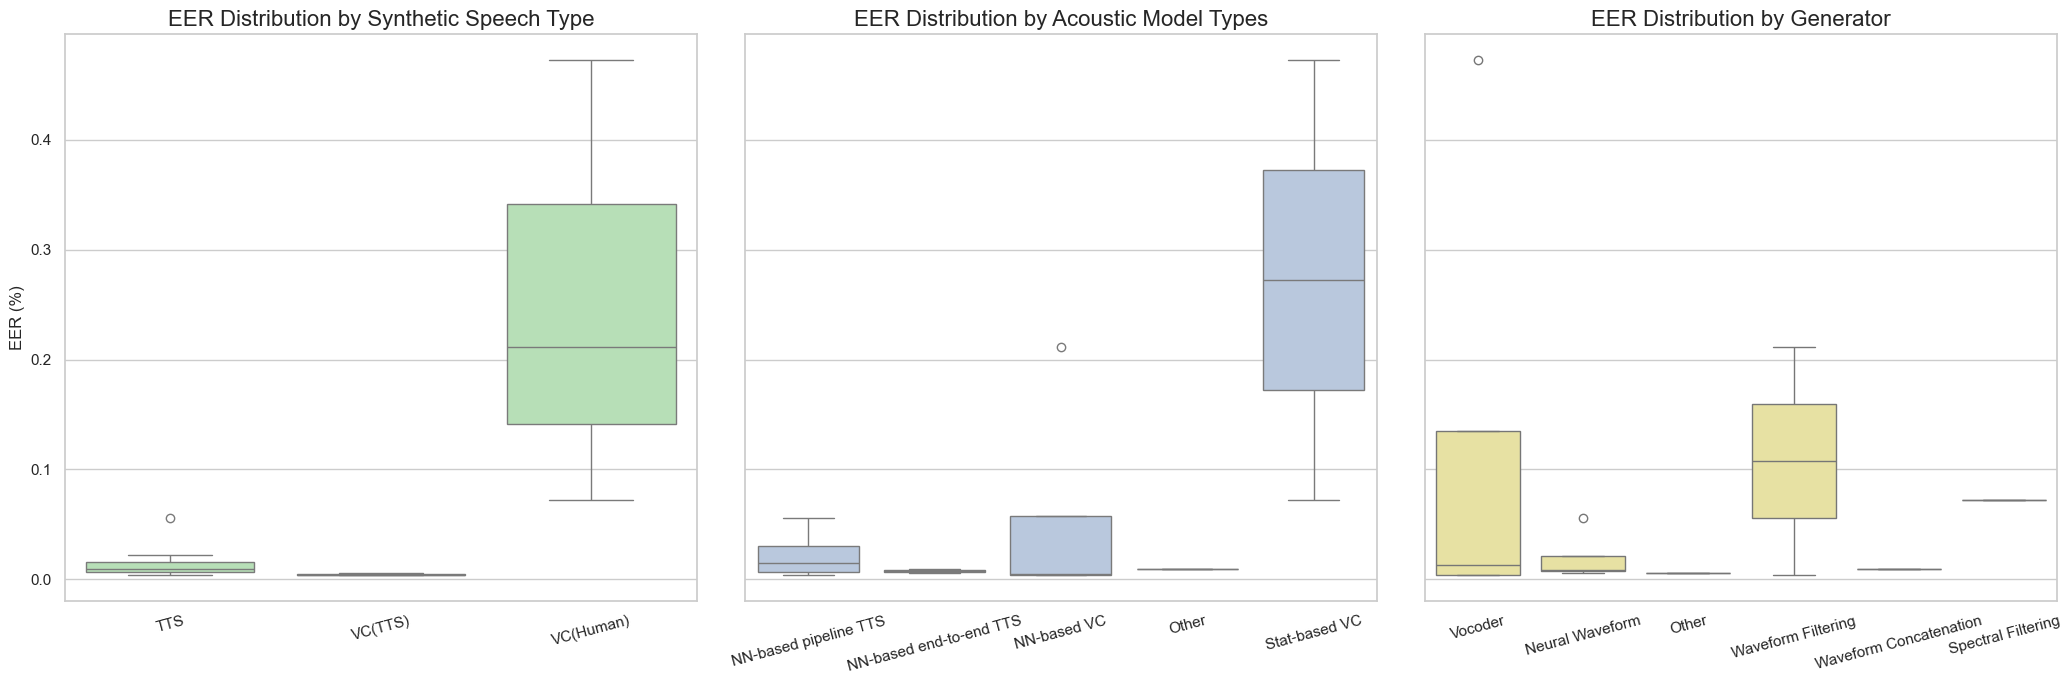

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define your attack type mappings ---

# Group 1: Primary Attack Type
group1_mapping = {
    'TTS': ['A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A16'],
    'VC(TTS)': ['A13', 'A14', 'A15'],
    'VC(Human)': ['A17', 'A18', 'A19']
}

# Group 2: Core Model Paradigm (based on your latest specified groupings)
group2_mapping = {
    'NN-based pipeline TTS': ['A07', 'A08', 'A09', 'A12'],
    'NN-based end-to-end TTS': ['A10', 'A11'],
    'NN-based VC': ['A13', 'A14', 'A15', 'A17'],
    'Stat-based VC': ['A18', 'A19']
}

# Group 3: generator
group3_mapping = {
    'Neural Waveform': ['A08', 'A10', 'A12', 'A15'],
    'Vocoder': ['A07', 'A09', 'A14', 'A18'],
    'Waveform Filtering': ['A13', 'A17'],
    'Spectral Filtering': ['A19'],
    'Waveform Concatenation': ['A16'],
    'Other': ['A11']
}

# --- 2. Create a Sample DataFrame (Simulating multiple runs for box plots) ---
art = api.artifact(f"qianyue-university-of-stuttgart/teamlab_deepfake/run-iy7stjxs-per_attack_analysis_table:v0")
table = art.get("per_attack_analysis_table")

# Convert the wandb.Table to a pandas DataFrame
# Following from the last code example:
df = table.get_dataframe()

num_runs = 10 # Number of simulated runs for each attack type
data_rows = []


print("Sample DataFrame Head:")
print(df.head())
print("\nSample DataFrame Info:")
print(df.info())

# --- 3. Prepare data for plotting ---

# Create 'Group_1_Category' column
df['Group_1_Category'] = df['attack_type'].apply(
    lambda x: next((category for category, types in group1_mapping.items() if x in types), 'Other')
)

# Create 'Group_2_Category' column
df['Group_2_Category'] = df['attack_type'].apply(
    lambda x: next((category for category, types in group2_mapping.items() if x in types), 'Other')
)

# Create 'Group_3_Category' column
df['Group_3_Category'] = df['attack_type'].apply(
    lambda x: next((category for category, types in group3_mapping.items() if x in types), 'Other')
)

print("\nDataFrame with Categories Head:")
print(df.head())

# --- 4. Create the Box Plots ---

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

# Define custom colors for the two groups
custom_colors = {
    'light_blue': '#B3C7E3', # Estimated color from left box
    'light_green': '#B0E6B0', # Estimated color from right box
    'light_yellow': "#F2EA98"
}
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True) # sharey=True ensures same Y-axis scale

# Plot for Group 1: Primary Attack Type
sns.boxplot(
    x='Group_1_Category',
    y='optimal_eer',
    data=df,
    ax=axes[0],
    color=custom_colors['light_green'],
    showfliers=True # Show outliers
)
axes[0].set_title('EER Distribution by Synthetic Speech Type', fontsize=16)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('EER (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=15) # Rotate labels for readability

# Plot for Group 2: Core Model Paradigm
sns.boxplot(
    x='Group_2_Category',
    y='optimal_eer',
    data=df,
    ax=axes[1],
    color=custom_colors['light_blue'],
    showfliers=True # Show outliers
)
axes[1].set_title('EER Distribution by Acoustic Model Types', fontsize=16)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('') # Y-label already on left subplot
axes[1].tick_params(axis='x', rotation=15) # Rotate labels for readability

# Plot for Group 3: Generator
sns.boxplot(
    x='Group_3_Category',
    y='optimal_eer',
    data=df,
    ax=axes[2],
    color=custom_colors['light_yellow'],
    showfliers=True # Show outliers
)
axes[2].set_title('EER Distribution by Generator', fontsize=16)
axes[2].set_xlabel('', fontsize=12)
axes[2].set_ylabel('') # Y-label already on left subplot
axes[2].tick_params(axis='x', rotation=15) # Rotate labels for readability

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

### Potential Improvement